In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 31.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 29.8 MB/s 
     |████████████████████████████████| 1.8 MB 52.9 MB/s 
     |████████████████████████████████| 103 kB 82.2 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    n_geographic_split = 24
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1,1.0,140
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1,0.0,102
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0,0.0,215
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0,1.0,162
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1,1.0,140


<BarContainer object of 155 artists>

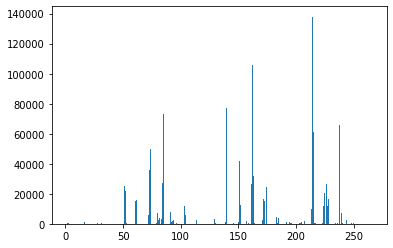

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

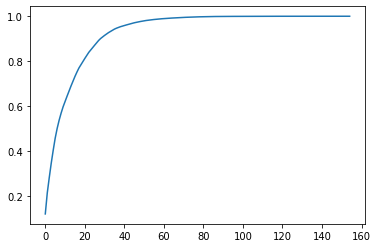

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/137 [00:00<?, ?it/s]

Start knn
Start knn grouped by latlon_section


  0%|          | 0/146 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13608979
Pos rate: 0.07402164409247747
                        id          match_id     kdist  kneighbors  \
741894    E_4d97f23f0cf767  E_eedc7310ce4026  0.000159         1.0   
6463530   E_59ff8aafa78609  E_4cd5027d62c2a2  0.000782        11.0   
4325333   E_98acfecfde921c  E_63a1cc6428076b  0.007941         7.0   
3708857   E_839aeb9b760888  E_069df801b4959f  0.002648         6.0   
13029389  E_afc1b18c61fbc2  E_6972c7571eda36       NaN         NaN   

         point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
741894    P_0c6c7742d48b27       0.000082                 2.0    0.940764   
6463530   P_8c84ed35d1287f       0.000762                18.0    0.026540   
4325333   P_2561df6b2d328f       0.006832                 8.0    0.162421   
3708857   P_ace65bc06b7f11       0.002620                 7.0    0.010786   
13029389  P_bf0a13d5a204a2       0.003998                 3.0         NaN   

          kneighbors_me

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9227816802366877


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.60%,7.40%
development set - fold 0,92.60%,7.40%
validation set - fold 0,92.60%,7.40%
development set - fold 1,92.60%,7.40%
validation set - fold 1,92.60%,7.40%
development set - fold 2,92.60%,7.40%
validation set - fold 2,92.60%,7.40%
development set - fold 3,92.60%,7.40%
validation set - fold 3,92.60%,7.40%
development set - fold 4,92.60%,7.40%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0450311
[100]	valid_0's binary_logloss: 0.0430453
[150]	valid_0's binary_logloss: 0.0421069
[200]	valid_0's binary_logloss: 0.041515
[250]	valid_0's binary_logloss: 0.0410434
[300]	valid_0's binary_logloss: 0.0406558
[350]	valid_0's binary_logloss: 0.0403231
[400]	valid_0's binary_logloss: 0.0400081
[450]	valid_0's binary_logloss: 0.0396719
[500]	valid_0's binary_logloss: 0.0394484
[550]	valid_0's binary_logloss: 0.039207
[600]	valid_0's binary_logloss: 0.0390225
[650]	valid_0's binary_logloss: 0.0388313
[700]	valid_0's binary_logloss: 0.0386494
[750]	valid_0's binary_logloss: 0.0384753
[800]	valid_0's binary_logloss: 0.0383005
[850]	valid_0's binary_logloss: 0.0381419
[900]	valid_0's binary_logloss: 0.0379733
[950]	valid_0's binary_logloss: 0.0378009
[1000]	valid_0's binary_logloss: 0.0376316
[1050]	valid_0's binary_logloss: 0.0374981
[1100]	valid_0's binary_logloss: 0.0373602
[1150]	valid_0's binary_logloss: 0.0372039
[1200]	valid_0's binary_logloss: 

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

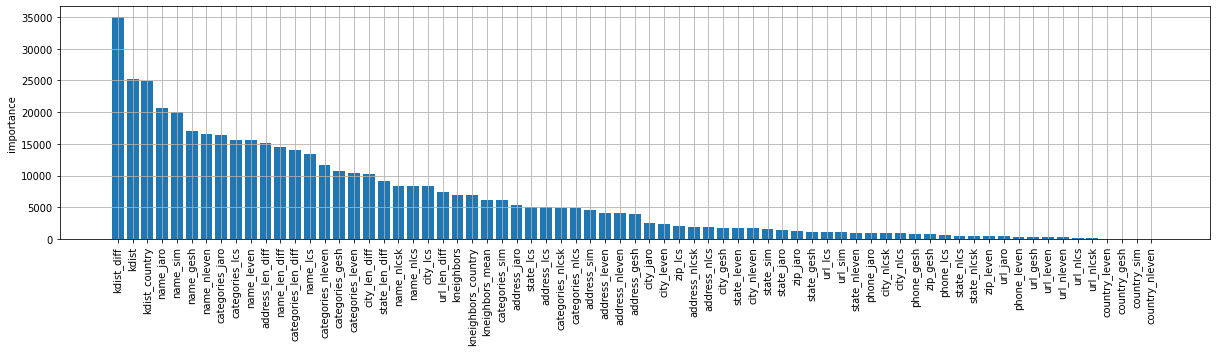

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 27.2 MB/s 
     |████████████████████████████████| 81 kB 10.3 MB/s 
     |████████████████████████████████| 210 kB 69.4 MB/s 
     |████████████████████████████████| 78 kB 9.5 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 78.9 MB/s 
     |████████████████████████████████| 146 kB 73.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7501ea4358df9bf0a8248702006f284a5231e3d5275a36dd987c6497c7acfff6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 18:22:07,870] A new study created in memory with name: no-name-6194ba31-2187-461f-b3f8-9ce12443b2e1
[I 2022-05-25 18:22:35,665] Trial 0 finished with value: 0.8128316534318278 and parameters: {'threshold': 0.9004274086209774}. Best is trial 0 with value: 0.8128316534318278.


CV: 0.812832


[I 2022-05-25 18:22:55,649] Trial 1 finished with value: 0.8119129572323601 and parameters: {'threshold': 0.9060907479492654}. Best is trial 0 with value: 0.8128316534318278.


CV: 0.811913


[I 2022-05-25 18:23:15,253] Trial 2 finished with value: 0.8268714095103009 and parameters: {'threshold': 0.5120810296618488}. Best is trial 2 with value: 0.8268714095103009.


CV: 0.826871


[I 2022-05-25 18:23:37,543] Trial 3 finished with value: 0.6994615492184175 and parameters: {'threshold': 0.019962105594923063}. Best is trial 2 with value: 0.8268714095103009.


CV: 0.699462


[I 2022-05-25 18:23:58,338] Trial 4 finished with value: 0.7721581516180852 and parameters: {'threshold': 0.07605205822789207}. Best is trial 2 with value: 0.8268714095103009.


CV: 0.772158


[I 2022-05-25 18:24:16,798] Trial 5 finished with value: 0.8274954509873482 and parameters: {'threshold': 0.6471153781894461}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.827495


[I 2022-05-25 18:24:36,214] Trial 6 finished with value: 0.8264226583615956 and parameters: {'threshold': 0.48604970642962164}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.826423


[I 2022-05-25 18:24:55,592] Trial 7 finished with value: 0.8273867000312761 and parameters: {'threshold': 0.6595909944437751}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.827387


[I 2022-05-25 18:25:14,896] Trial 8 finished with value: 0.803603560800604 and parameters: {'threshold': 0.17862397127808705}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.803604


[I 2022-05-25 18:25:34,071] Trial 9 finished with value: 0.823710106171098 and parameters: {'threshold': 0.7893523228436672}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.823710


[I 2022-05-25 18:25:53,767] Trial 10 finished with value: 0.817328117303321 and parameters: {'threshold': 0.29642205687336154}. Best is trial 5 with value: 0.8274954509873482.


CV: 0.817328


[I 2022-05-25 18:26:12,203] Trial 11 finished with value: 0.8276967070403249 and parameters: {'threshold': 0.6232247207657853}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.827697


[I 2022-05-25 18:26:31,431] Trial 12 finished with value: 0.8276865052442902 and parameters: {'threshold': 0.6269639217190031}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.827687


[I 2022-05-25 18:26:51,852] Trial 13 finished with value: 0.8248332644462946 and parameters: {'threshold': 0.4334157222282806}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.824833


[I 2022-05-25 18:27:10,268] Trial 14 finished with value: 0.826881403422066 and parameters: {'threshold': 0.6916673719027879}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.826881


[I 2022-05-25 18:27:29,875] Trial 15 finished with value: 0.8219205894434877 and parameters: {'threshold': 0.3675962079290245}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.821921


[I 2022-05-25 18:27:49,199] Trial 16 finished with value: 0.8276928285853697 and parameters: {'threshold': 0.5784919002723393}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.827693


[I 2022-05-25 18:28:08,197] Trial 17 finished with value: 0.8239264067411702 and parameters: {'threshold': 0.7838648686591184}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.823926


[I 2022-05-25 18:28:26,786] Trial 18 finished with value: 0.8274962163386368 and parameters: {'threshold': 0.5535714109680666}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.827496


[I 2022-05-25 18:28:46,568] Trial 19 finished with value: 0.8167423904306829 and parameters: {'threshold': 0.2890535765352464}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.816742


[I 2022-05-25 18:29:05,006] Trial 20 finished with value: 0.7790542131659169 and parameters: {'threshold': 0.9813891872358416}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.779054


[I 2022-05-25 18:29:24,358] Trial 21 finished with value: 0.8276962106403207 and parameters: {'threshold': 0.5745364195423668}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.827696


[I 2022-05-25 18:29:43,518] Trial 22 finished with value: 0.825136320136433 and parameters: {'threshold': 0.7539028607687404}. Best is trial 11 with value: 0.8276967070403249.


CV: 0.825136


[I 2022-05-25 18:30:01,989] Trial 23 finished with value: 0.8277775402349354 and parameters: {'threshold': 0.5874002487264138}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.827778


[I 2022-05-25 18:30:21,467] Trial 24 finished with value: 0.8245750363198341 and parameters: {'threshold': 0.42644177593429416}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.824575


[I 2022-05-25 18:30:39,586] Trial 25 finished with value: 0.8263922211421181 and parameters: {'threshold': 0.7196922125943355}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.826392


[I 2022-05-25 18:30:59,993] Trial 26 finished with value: 0.8193410883403704 and parameters: {'threshold': 0.8507246542771154}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.819341


[I 2022-05-25 18:31:19,358] Trial 27 finished with value: 0.8277497418088727 and parameters: {'threshold': 0.5816001109715034}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.827750


[I 2022-05-25 18:31:38,046] Trial 28 finished with value: 0.8196815545980981 and parameters: {'threshold': 0.3304563557904885}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.819682


[I 2022-05-25 18:31:57,381] Trial 29 finished with value: 0.8244395637645847 and parameters: {'threshold': 0.422949712788401}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.824440


[I 2022-05-25 18:32:16,888] Trial 30 finished with value: 0.8266096063715066 and parameters: {'threshold': 0.5012148617430601}. Best is trial 23 with value: 0.8277775402349354.


CV: 0.826610


[I 2022-05-25 18:32:35,217] Trial 31 finished with value: 0.8277852033828726 and parameters: {'threshold': 0.5882981494685696}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827785


[I 2022-05-25 18:32:54,409] Trial 32 finished with value: 0.8277646731979723 and parameters: {'threshold': 0.5952642697255134}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827765


[I 2022-05-25 18:33:13,792] Trial 33 finished with value: 0.8275803867306838 and parameters: {'threshold': 0.5588519024733829}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827580


[I 2022-05-25 18:33:31,812] Trial 34 finished with value: 0.8196633704748745 and parameters: {'threshold': 0.8470942416315657}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.819663


[I 2022-05-25 18:33:51,158] Trial 35 finished with value: 0.8264100007034798 and parameters: {'threshold': 0.4849561451262426}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.826410


[I 2022-05-25 18:34:10,254] Trial 36 finished with value: 0.8267044220221808 and parameters: {'threshold': 0.7064580526862686}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.826704


[I 2022-05-25 18:34:28,648] Trial 37 finished with value: 0.8277632575711146 and parameters: {'threshold': 0.5981522753241992}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827763


[I 2022-05-25 18:34:47,697] Trial 38 finished with value: 0.8274571171202704 and parameters: {'threshold': 0.6552621842468975}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827457


[I 2022-05-25 18:35:09,680] Trial 39 finished with value: 0.8270486462086113 and parameters: {'threshold': 0.5258977024671919}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827049


[I 2022-05-25 18:35:29,162] Trial 40 finished with value: 0.8257786739338941 and parameters: {'threshold': 0.45967025616830287}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.825779


[I 2022-05-25 18:35:48,447] Trial 41 finished with value: 0.8276323972294731 and parameters: {'threshold': 0.6290333722152064}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827632


[I 2022-05-25 18:36:06,799] Trial 42 finished with value: 0.8277842798521825 and parameters: {'threshold': 0.5976179518117679}. Best is trial 31 with value: 0.8277852033828726.


CV: 0.827784


[I 2022-05-25 18:36:26,144] Trial 43 finished with value: 0.827795151826577 and parameters: {'threshold': 0.6015560044907375}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827795


[I 2022-05-25 18:36:44,586] Trial 44 finished with value: 0.827043649621143 and parameters: {'threshold': 0.5254229684418545}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827044


[I 2022-05-25 18:37:03,857] Trial 45 finished with value: 0.8270867193760426 and parameters: {'threshold': 0.6826291448975039}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827087


[I 2022-05-25 18:37:22,499] Trial 46 finished with value: 0.8223606599566624 and parameters: {'threshold': 0.37729765683982447}. Best is trial 43 with value: 0.827795151826577.


CV: 0.822361


[I 2022-05-25 18:37:41,612] Trial 47 finished with value: 0.8253508728622236 and parameters: {'threshold': 0.7476738151584476}. Best is trial 43 with value: 0.827795151826577.


CV: 0.825351


[I 2022-05-25 18:38:01,627] Trial 48 finished with value: 0.8082744166078357 and parameters: {'threshold': 0.2093450371822349}. Best is trial 43 with value: 0.827795151826577.


CV: 0.808274


[I 2022-05-25 18:38:20,424] Trial 49 finished with value: 0.8277119838834167 and parameters: {'threshold': 0.61958391910398}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827712


[I 2022-05-25 18:38:39,491] Trial 50 finished with value: 0.8216619929118986 and parameters: {'threshold': 0.8227182092933691}. Best is trial 43 with value: 0.827795151826577.


CV: 0.821662


[I 2022-05-25 18:38:58,847] Trial 51 finished with value: 0.827692607105686 and parameters: {'threshold': 0.6252742691066803}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827693


[I 2022-05-25 18:39:18,486] Trial 52 finished with value: 0.8277779539861945 and parameters: {'threshold': 0.590764265985266}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827778


[I 2022-05-25 18:39:36,934] Trial 53 finished with value: 0.827367148806592 and parameters: {'threshold': 0.6652050459269235}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827367


[I 2022-05-25 18:39:56,456] Trial 54 finished with value: 0.8272194657129743 and parameters: {'threshold': 0.537731802200628}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827219


[I 2022-05-25 18:40:15,277] Trial 55 finished with value: 0.8261711348291662 and parameters: {'threshold': 0.4743926526958461}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826171


[I 2022-05-25 18:40:34,372] Trial 56 finished with value: 0.825987777867903 and parameters: {'threshold': 0.7313258628560321}. Best is trial 43 with value: 0.827795151826577.


CV: 0.825988


[I 2022-05-25 18:40:53,660] Trial 57 finished with value: 0.8272129652279977 and parameters: {'threshold': 0.6764837657625714}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827213


[I 2022-05-25 18:41:16,649] Trial 58 finished with value: 0.6508756673336131 and parameters: {'threshold': 0.010117177862439375}. Best is trial 43 with value: 0.827795151826577.


CV: 0.650876


[I 2022-05-25 18:41:35,010] Trial 59 finished with value: 0.8277362244777546 and parameters: {'threshold': 0.59335132491686}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827736


[I 2022-05-25 18:41:53,917] Trial 60 finished with value: 0.8239545221583912 and parameters: {'threshold': 0.7826725936844987}. Best is trial 43 with value: 0.827795151826577.


CV: 0.823955


[I 2022-05-25 18:42:12,384] Trial 61 finished with value: 0.827772977467508 and parameters: {'threshold': 0.5898265812436979}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827773


[I 2022-05-25 18:42:31,617] Trial 62 finished with value: 0.8273541346369571 and parameters: {'threshold': 0.5464613287026377}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827354


[I 2022-05-25 18:42:50,793] Trial 63 finished with value: 0.8277396241714249 and parameters: {'threshold': 0.6078414986818828}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827740


[I 2022-05-25 18:43:09,183] Trial 64 finished with value: 0.8274838038099291 and parameters: {'threshold': 0.6476962155595013}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827484


[I 2022-05-25 18:43:28,654] Trial 65 finished with value: 0.826783846093344 and parameters: {'threshold': 0.5076207411968824}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826784


[I 2022-05-25 18:43:48,159] Trial 66 finished with value: 0.827677048121376 and parameters: {'threshold': 0.5693082813998628}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827677


[I 2022-05-25 18:44:06,907] Trial 67 finished with value: 0.8254085270770065 and parameters: {'threshold': 0.4503858105881391}. Best is trial 43 with value: 0.827795151826577.


CV: 0.825409


[I 2022-05-25 18:44:26,267] Trial 68 finished with value: 0.8268959013508294 and parameters: {'threshold': 0.6914332041536335}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826896


[I 2022-05-25 18:44:44,901] Trial 69 finished with value: 0.8276373403710493 and parameters: {'threshold': 0.5630672274501578}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827637


[I 2022-05-25 18:45:04,362] Trial 70 finished with value: 0.8267865287523507 and parameters: {'threshold': 0.5078011660346046}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826787


[I 2022-05-25 18:45:23,692] Trial 71 finished with value: 0.8277669974973589 and parameters: {'threshold': 0.5947304581520207}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827767


[I 2022-05-25 18:45:42,115] Trial 72 finished with value: 0.827783061140347 and parameters: {'threshold': 0.5975325100261218}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827783


[I 2022-05-25 18:46:01,285] Trial 73 finished with value: 0.8275540893789987 and parameters: {'threshold': 0.6387872251447771}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827554


[I 2022-05-25 18:46:20,544] Trial 74 finished with value: 0.8277678206937813 and parameters: {'threshold': 0.5913453731780945}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827768


[I 2022-05-25 18:46:39,044] Trial 75 finished with value: 0.8273200271540964 and parameters: {'threshold': 0.5429772209245245}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827320


[I 2022-05-25 18:46:58,200] Trial 76 finished with value: 0.8273732763596641 and parameters: {'threshold': 0.6615043945813175}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827373


[I 2022-05-25 18:47:17,742] Trial 77 finished with value: 0.8276767097816213 and parameters: {'threshold': 0.5735407891619536}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827677


[I 2022-05-25 18:47:37,302] Trial 78 finished with value: 0.8229474947845891 and parameters: {'threshold': 0.3890863138429566}. Best is trial 43 with value: 0.827795151826577.


CV: 0.822947


[I 2022-05-25 18:47:55,592] Trial 79 finished with value: 0.8267226829856986 and parameters: {'threshold': 0.701896423196992}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826723


[I 2022-05-25 18:48:14,968] Trial 80 finished with value: 0.8263623928259382 and parameters: {'threshold': 0.4825992408481383}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826362


[I 2022-05-25 18:48:33,563] Trial 81 finished with value: 0.8277914739043163 and parameters: {'threshold': 0.5881143364829493}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827791


[I 2022-05-25 18:48:52,935] Trial 82 finished with value: 0.8276886343036153 and parameters: {'threshold': 0.6257309854484439}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827689


[I 2022-05-25 18:49:14,089] Trial 83 finished with value: 0.7511495806437585 and parameters: {'threshold': 0.04851418369914762}. Best is trial 43 with value: 0.827795151826577.


CV: 0.751150


[I 2022-05-25 18:49:32,743] Trial 84 finished with value: 0.8269492886809048 and parameters: {'threshold': 0.5172661550747197}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826949


[I 2022-05-25 18:49:52,008] Trial 85 finished with value: 0.8277161839487387 and parameters: {'threshold': 0.6086443000106047}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827716


[I 2022-05-25 18:50:11,496] Trial 86 finished with value: 0.8273397059563686 and parameters: {'threshold': 0.5472416846371928}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827340


[I 2022-05-25 18:50:30,022] Trial 87 finished with value: 0.8275261776964122 and parameters: {'threshold': 0.6413156820179274}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827526


[I 2022-05-25 18:50:49,289] Trial 88 finished with value: 0.8276387714864497 and parameters: {'threshold': 0.5663503043061259}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827639


[I 2022-05-25 18:51:08,495] Trial 89 finished with value: 0.8261305827174421 and parameters: {'threshold': 0.725927062926636}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826131


[I 2022-05-25 18:51:27,973] Trial 90 finished with value: 0.8277939982434582 and parameters: {'threshold': 0.6028127135684764}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827794


[I 2022-05-25 18:51:46,406] Trial 91 finished with value: 0.8277921475594686 and parameters: {'threshold': 0.5853950740611239}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827792


[I 2022-05-25 18:52:05,783] Trial 92 finished with value: 0.8273019140526706 and parameters: {'threshold': 0.6694125144541168}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827302


[I 2022-05-25 18:52:24,520] Trial 93 finished with value: 0.8271152745083082 and parameters: {'threshold': 0.5294570362539375}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827115


[I 2022-05-25 18:52:43,905] Trial 94 finished with value: 0.8276861517227874 and parameters: {'threshold': 0.6163596099089103}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827686


[I 2022-05-25 18:53:03,296] Trial 95 finished with value: 0.827678182488251 and parameters: {'threshold': 0.573835344565533}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827678


[I 2022-05-25 18:53:22,755] Trial 96 finished with value: 0.8274410889132262 and parameters: {'threshold': 0.6500491407119537}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827441


[I 2022-05-25 18:53:41,179] Trial 97 finished with value: 0.8277705134051643 and parameters: {'threshold': 0.6060470607523696}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827771


[I 2022-05-25 18:54:00,477] Trial 98 finished with value: 0.8277480997781205 and parameters: {'threshold': 0.582606685884551}. Best is trial 43 with value: 0.827795151826577.


CV: 0.827748


[I 2022-05-25 18:54:19,962] Trial 99 finished with value: 0.8265097879693123 and parameters: {'threshold': 0.49524544207391985}. Best is trial 43 with value: 0.827795151826577.


CV: 0.826510


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6015560044907375

In [ ]:
study.best_value

0.827795151826577

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827795


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,140871.000000,140871.000000,137394.000000,137394.000000,132457.000000,144799.000000,144799.0,144799.000000,144799.000000,144799.000000,...,144799.000000,144795.000000,144795.000000,144795.000000,144795.000000,144799.000000,144795.000000,144795.000000,144795.000000,1.447990e+05
mean,0.006360,6.161871,0.003855,6.176085,0.421946,6.440193,1.0,0.264064,0.411361,16.499168,...,0.998985,0.999092,0.001851,0.999088,1.998184,0.000028,0.000925,0.999092,0.999092,1.806726e-01
std,0.048802,5.235340,0.032087,5.240759,2.261473,5.303898,0.0,0.311020,0.250650,9.480436,...,0.031846,0.029631,0.060129,0.029873,0.059262,0.005256,0.030065,0.029631,0.029631,1.866732e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.224580e-13
25%,0.000438,2.000000,0.000331,2.000000,0.005935,2.000000,1.0,0.000000,0.208333,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.542885e-02
50%,0.001106,4.000000,0.000862,4.000000,0.056828,5.000000,1.0,0.000000,0.392857,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.064053e-01
75%,0.003026,10.000000,0.002387,10.000000,0.320474,10.000000,1.0,0.514476,0.591549,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.219837e-01
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.015503e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
4860111,E_88e0de87f2ffe8,E_1dc2e8a1d2b28a,0.000444,8.0,P_160c95c628b31d,0.000440,8.0,8.631534e-03,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.018749
4395986,E_b8110c8bd67887,E_7816d33bb6f593,0.008152,7.0,P_57c3febb6774fb,0.005079,9.0,6.050947e-01,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000014
6656025,E_b03ff6b880c64e,E_4a445d1cdaaa62,0.007069,11.0,P_ebb560a39edf6e,0.007035,16.0,4.912566e-03,13.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.034333
9488865,E_a9e06e3bfa9b47,E_27a02d1f798ad8,0.007627,16.0,P_2769dafac3aa32,0.007002,14.0,8.929658e-02,15.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.009045
1372422,E_68d7f13922b114,E_df1b72dc265157,0.000268,2.0,P_c822e868b47d14,0.000267,2.0,5.035773e-03,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.290570
1856473,E_428a02b716edf7,E_03a077f5deb1c7,0.001115,3.0,P_6fa6ec8cfd6d25,0.001113,7.0,1.529417e-03,5.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.042567
7558724,E_463db8856b19d0,E_c23de61437cc30,0.000152,13.0,NaN,NaN,NaN,NaN,13.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.153296
644028,E_217a1677705e74,E_96b7aa2e78d73d,0.000590,1.0,P_6fa2a6c59dfd18,0.000372,1.0,5.883064e-01,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.044295
9822126,E_3fcf97255df9a3,E_b22fe34868a381,0.001195,17.0,P_68be589660b916,0.001188,17.0,5.803545e-03,17.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.260539
2576215,E_860699cf48c9aa,E_bd9708e2068498,0.000526,4.0,P_256147b8462d4f,0.000503,5.0,4.502032e-02,4.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.014211


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
567426,E_7f87daea4bf411,Taman Kuliner Kali Bata,-6.255417,106.847467,Kali Bata,Jakarta Selatan,DKI Jakarta,NaN,ID,NaN,NaN,Food Courts,P_ff07224987c3b7,4,1.0,214
934700,E_d1f65e4c05dcae,Pusat Kuliner & Jajanan Malam TMP Kalibata ~ #...,-6.255430,106.847260,Jln. Taman Makam Pahlawan (TMP) Kalibata,Pancoran,Jakarta,12740,ID,NaN,NaN,Street Food Gatherings,P_ff07224987c3b7,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
792579,E_b205b2d6c74777,Pool Side Permata Jingga,-7.931620,112.618192,Permata Jingga,Malang,East Java,NaN,ID,NaN,NaN,NaN,P_1921e1eeed1382,4,1.0,224
1011724,E_e3476698ddaee5,Permata Jingga,-7.929306,112.618791,NaN,Malang,East-Java,NaN,ID,NaN,NaN,Housing Developments,P_1921e1eeed1382,4,1.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
202245,E_2d6005edb8b24d,Легенда Байкала,51.873237,104.828639,NaN,Листвянка,Иркутская обл.,NaN,RU,NaN,NaN,Hotels,P_57fdcdccb8ae96,2,1.0,217
1052128,E_ec67affed4e030,Legend of Baikal,51.872901,104.828559,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_57fdcdccb8ae96,2,1.0,217


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
814123,E_b6d4c49b5029ed,Yoğurtçu Parkı,40.985925,29.033818,NaN,NaN,NaN,NaN,TR,NaN,NaN,Parks,P_4dfd12bf490966,4,1.0,162
1111980,E_f9f5dbb2fd1c13,Kadıköy Yoğurtçu Parkı,40.987703,29.033767,NaN,NaN,NaN,NaN,TR,NaN,NaN,Harbors / Marinas,P_4dfd12bf490966,4,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
130657,E_1d4ad66f30527c,โรงเรียนนารีรัตน์จังหวัดแพร่ (Nareerat School ...,18.143289,100.139547,1 Khum Doem Rd.,Phrae,Thailand,54000,TH,http://www.nareerat.ac.th,54511124,High Schools,P_0ae29c84c40fc9,1,1.0,215
132863,E_1dc67cbe4c5ac9,โรงหนังโรงเรียนนารีรัตน์ที่มีเเอร์เเต่ไม่เย็น,18.143143,100.140077,NaN,NaN,NaN,NaN,TH,NaN,NaN,TV Stations,P_0ae29c84c40fc9,1,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
553900,E_7c801e89bf82e2,Туризм,48.505790,35.087590,NaN,NaN,NaN,NaN,UA,NaN,NaN,General Entertainment,P_de41dbf54afaa2,4,1.0,162
768056,E_ac8504ae8e82ad,Физика,48.506245,35.088824,Гули Королевой 14 Б,Днепропетровск,NaN,NaN,UA,NaN,NaN,College Classrooms,P_de41dbf54afaa2,4,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
318124,E_477e9884def0cb,Concierge Lounge At Orlando Hilton,28.425282,-81.456890,NaN,Orlando,FL,32819,US,NaN,NaN,Hotels,P_fd8e082e552fa8,4,1.0,84
718874,E_a17d6826427255,The Scene Cafe & Resort Lounge,28.424920,-81.456986,Hawaiian Court,NaN,NaN,NaN,US,NaN,NaN,Bars,P_fd8e082e552fa8,4,1.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
59062,E_0d35a874a52455,Doceria Ofner,-23.672068,-46.70866,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_913e4f6918b818,2,1.0,102
167485,E_258addf40450a7,Ofner - Matriz (Fábrica dos doces),-23.672626,-46.71101,avenida rio bonito,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_913e4f6918b818,2,1.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
41972,E_09623d32f8d367,Ruang Komputer SMAN 26 Jakarta,-6.233969,106.848536,Jalan Tebet Barat IV,Jakarta Selatan,NaN,NaN,ID,NaN,NaN,College Technology Buildings,P_6a3604be021d94,4,1.0,214
575196,E_814ace738f3aef,Ruang OSIS SMAN 26,-6.233181,106.850932,Jl. Tebet Barat IV,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_6a3604be021d94,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
700540,E_9d560fd17e2236,egekent 2 gökçe çikolata,38.556420,27.049604,NaN,NaN,NaN,NaN,TR,NaN,NaN,Chocolate Shops,P_9719113145cf7e,2,1.0,162
752844,E_a9197953547da5,Gökçe Pastanesi,38.555463,27.049834,NaN,İzmir,İzmir,NaN,TR,NaN,NaN,"Pastry Shops, American Restaurants",P_9719113145cf7e,2,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
131256,E_1d6c394ad88e6a,Siem Reap Bus Terminal,13.348243,103.890324,NaN,Siem Reap,Siem Reap,NaN,KH,NaN,NaN,Bus Stations,P_2af121e0f90147,1,1.0,215
376986,E_54b2794917f320,Mekong Busil Terminal,13.348534,103.891112,NaN,NaN,NaN,NaN,KH,NaN,NaN,Bus Stations,P_2af121e0f90147,1,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
115018,E_19c7357d809b0b,Литература,59.956995,30.300502,,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_0652f3576e07fd,4,1.0,163
410527,E_5c452598357dba,Обж,59.956534,30.300155,29,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_0652f3576e07fd,4,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
244236,E_36ce516cafb4a0,AGH 9th floor 9C,40.457523,-80.003492,320 E North St,Pittsburgh,PA,NaN,US,NaN,NaN,Hospitals,P_4933dd69cb0a47,4,1.0,85
577550,E_81d7e8f646ada0,6th Floor AGH,40.457358,-80.003328,NaN,Pittsburgh,PA,15212,US,NaN,NaN,Hospitals,P_4933dd69cb0a47,4,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
652621,E_92a467afa7d68a,Ippudo - Westgate,1.333832,103.742473,NaN,NaN,NaN,NaN,SG,NaN,NaN,Music Venues,P_38e1a3e3a69cbe,1,1.0,214
943658,E_d3f8c14450fd46,一風堂 Ippudo,1.333859,103.742598,"#03-03, Westgate",Singapore,NaN,608532,SG,http://www.ippudo.com.sg/store/,64659308,"Ramen Restaurants, Japanese Restaurants",P_38e1a3e3a69cbe,1,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
889188,E_c7bd4a98885c33,Fen Edebiyat Fakültesi 209 No'lu Derslik,36.326763,36.196415,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Classrooms,P_db22a30d4d3961,1,1.0,161
991405,E_deb48fba8f2053,Fen Edebiyat Fakültesi 207 No'lu Drrslik,36.326813,36.200220,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Classrooms,P_db22a30d4d3961,1,1.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
290580,E_414034c8bed348,Watermark Pool Party,13.708659,100.500921,Chaophraya River,Bang Lamphu Lang,Bangkok,NaN,TH,NaN,NaN,Cocktail Bars,P_1df5e887ae1f6a,1,1.0,215
710609,E_9f9d06aaedc4bc,Swimming Pool,13.710472,100.501658,Watermark Chaophraya River,NaN,NaN,NaN,TH,NaN,NaN,Pools,P_1df5e887ae1f6a,1,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
182749,E_290079d4147049,Приморский парк Победы,59.969232,30.25197,"Крестовский просп., 21",Санкт-Петербург,Санкт-Петербург,197110,RU,http://www.primparkpobedy.ru,8122300456,Parks,P_9bc2a0265cacdb,4,1.0,163
261147,E_3aa1bd9b9334c5,Белки,59.970053,30.24290,NaN,город Санкт-Петербург,город Санкт-Петербург,NaN,RU,NaN,NaN,Parks,P_9bc2a0265cacdb,4,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
696859,E_9c86b26eec8b3d,"""Детский Медицинский Центр \""Большая Медведица\""""",55.888574,37.600708,"ул. Пришвина, 11",Москва,Москва,127549,RU,http://www.centramed.ru,4992076847,"Doctor's Offices, Medical Centers",P_f95ea3f006cbac,3,1.0,174
1125690,E_fd09dc4b1fad84,второй этаж 1413,55.888151,37.602065,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_f95ea3f006cbac,3,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
706331,E_9ea5ea912d86b8,Kolomna Hotel,55.094903,38.765299,NaN,NaN,NaN,NaN,RU,NaN,NaN,Hotels,P_757e3d88423e8a,3,1.0,174
764747,E_abc880ec4eabe8,"гостиница Коломна, бильярдный клуб",55.082962,38.768814,NaN,NaN,NaN,NaN,RU,NaN,NaN,Pool Halls,P_757e3d88423e8a,3,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
592345,E_85232c157f1616,Tebet barat dalam V,-6.236308,106.847542,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_5ee768a6643df1,1,1.0,214
643359,E_90a11f5d2bf00c,Jl Tebet Barat Dalam V,-6.236720,106.848616,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_5ee768a6643df1,1,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
563613,E_7ea90e86cd424b,Кабинет Алгебры,57.990103,56.256673,Героев Хасана 18,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_aea4febfaa62b1,4,1.0,185
812268,E_b669b1be4f1ad1,Кабинет истории и общаги😑😭🔫,57.990568,56.257513,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_aea4febfaa62b1,4,1.0,185


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
812861,E_b68b8510da8e3a,Mc.Donald's Taman Pinang Indah,-7.449266,112.704182,Perum. Taman Pinang Indah,Sidoarjo,"East Java, Indonesia",NaN,ID,NaN,NaN,"Fast Food Restaurants, Food & Drink Shops, Foo...",P_ae64626d6f858f,4,1.0,224
958932,E_d7691e33222aeb,Mc Donalds Sidoarjo,-7.448922,112.702442,Taman Pinang Indah,Sidoarjo,East Java,NaN,ID,NaN,NaN,Fast Food Restaurants,P_ae64626d6f858f,4,1.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
227511,E_3311a0a6478eec,Физика У Мирошникова,55.842497,37.350370,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_56accb29ae0844,4,1.0,163
656741,E_939407332d1d74,Кабинет Информатики,55.842244,37.349866,Барышиха 17,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_56accb29ae0844,4,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
722643,E_a25111ae0b4ddf,MAHMUTBEY GİŞELER,41.062928,28.799429,NaN,NaN,NaN,NaN,TR,NaN,NaN,Capitol Buildings,P_905228d7574458,4,1.0,162
933986,E_d1ccf0ca5e9dee,TEM - Mahmutbey Giseler - Edirne istikameti,41.062994,28.799133,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_905228d7574458,4,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
63005,E_0e1b28bcb40659,Mandarine Koueider,30.089610,31.322310,5 Baghdad St,Heliopolis,NaN,11351,EG,https://mandarine-koueider.com,+20224186555,"Pastry Shops, Ice Cream Shops, Bakeries",P_2f40a6ff321edf,1,1.0,161
596978,E_862bb26ea86715,Koueider,30.090515,31.323628,NaN,NaN,NaN,NaN,EG,NaN,NaN,Dessert Shops,P_2f40a6ff321edf,1,1.0,161


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
52624,E_0bc9327cd13b02,"""International Hospitality Education \""NHI\""""",-6.868996,107.594090,Jalan Doktor Setiabudi 186,Bandung,Jawa Barat,40141,ID,NaN,222040921,"Universities, College Classrooms, Hotels",P_50e160bb810af4,4,1.0,214
752211,E_a8f9fd5d6e578b,Bandung Institute Of Tourism,-6.869902,107.594462,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_50e160bb810af4,4,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
481054,E_6c1c3c78bd170b,Sm Mall Of Asia Foot Bridge,14.536300,120.983344,SM Mall of Asia,Pasay,Metro Manila,NaN,PH,NaN,NaN,Bridges,P_5b2511ed5878ac,2,1.0,226
814481,E_b6e9f629716e33,SM Mall of Asia Passenger Terminal,14.536268,120.983255,"SM Mall of Asia, J. W. Diokno Blvd.",Pasay City,Metro Manila,1300,PH,NaN,NaN,"Bus Stations, General Travel",P_5b2511ed5878ac,2,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
524572,E_75df0c0fbd8989,Liverpool,19.434425,-99.182997,NaN,NaN,NaN,NaN,MX,NaN,NaN,Department Stores,P_ddd04db1b76df6,2,1.0,61
602305,E_875b38b348db98,Fashion Fest by Liverpool,19.432911,-99.183283,NaN,NaN,NaN,NaN,MX,NaN,NaN,Nightclubs,P_ddd04db1b76df6,2,1.0,61


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
306824,E_44e882059b7939,Pandawa Printing,-6.370959,106.834440,Jalan Margonda Raya,Depok,West Java,NaN,ID,NaN,NaN,NaN,P_3d30fc85b44617,2,1.0,214
533553,E_77ea7d2e3b63b0,Pandawa Printing Depok,-6.370395,106.833397,Jl.Margonda No: 397,Depok,West Java,NaN,ID,NaN,NaN,"Paper / Office Supplies Stores, Design Studios",P_3d30fc85b44617,2,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
976396,E_db56f5bb9a4ec6,"manchester, united kingdomm",53.364460,-2.268393,NaN,NaN,NaN,NaN,GB,NaN,NaN,General Travel,P_c1157d1bde3bd1,4,1.0,141
1047620,E_eb663dc88903b3,Manchester Airport (MAN),53.362226,-2.273789,Aviator Way,Manchester,Greater Manchester,M90 1QX,GB,http://www.manchesterairport.co.uk,8712710711,Airports,P_c1157d1bde3bd1,4,1.0,141


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,57277.000000,57277.000000,55769.000000,55769.000000,54107.000000,58433.000000,58433.0,58433.000000,58419.000000,58419.000000,...,58433.000000,58432.000000,58432.000000,58432.000000,58432.000000,58433.0,58432.000000,58432.000000,58432.000000,58433.000000
mean,0.009059,4.791155,0.003765,4.781814,0.414240,5.048175,0.0,0.572305,0.597349,12.351478,...,0.997929,0.998126,0.003953,0.998032,1.996252,0.0,0.001977,0.998126,0.998126,0.830282
std,0.114828,4.901605,0.020172,4.910710,1.656844,5.036564,0.0,0.352419,0.250390,9.366619,...,0.045459,0.042501,0.088543,0.044191,0.085002,0.0,0.044271,0.042501,0.042501,0.124959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.601560
25%,0.000308,1.000000,0.000236,1.000000,0.007327,1.000000,0.0,0.318084,0.432432,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.719862
50%,0.000905,3.000000,0.000679,2.000000,0.064742,3.000000,0.0,0.637404,0.611111,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.843368
75%,0.003132,7.000000,0.002349,7.000000,0.314958,7.500000,0.0,0.868126,0.785714,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.949071
max,11.519732,19.000000,1.385816,19.000000,85.764924,19.000000,0.0,1.000000,1.000000,58.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
2416453,E_3e43d0225ab850,E_fcf656051e3637,0.000470,4.0,P_54b5b96ee8dab3,0.000466,4.0,0.007962,4.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.705936
9470714,E_a1b551330fd276,E_e05e8e27ff6f2f,3.569911,16.0,NaN,NaN,NaN,NaN,16.0,0,...,0.0,0.5,1.0,0.666667,1.0,0,0.5,0.5,0.5,0.697707
3296460,E_c9e0746511bb32,E_d276a768859d95,0.002448,5.0,P_4635b670978b5c,0.002234,5.0,0.096006,5.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.999844
13352366,E_0339f6f0bf70c9,E_f946aceb4d091e,NaN,NaN,P_07cbb7bb128b7b,0.057381,17.0,NaN,17.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.921265
1124857,E_f9a77eac62969a,E_ec7b4f7ce21826,0.000389,1.0,P_1f4b6c1db19d39,0.000383,1.0,0.014022,1.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.882750
700162,E_3aa461f77bd3df,E_d6105b6f178dff,0.001637,1.0,P_70096f36989c2b,0.001632,1.0,0.002867,1.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.796438
1263504,E_37e76d961efa3f,E_ba09065e28bc18,0.000069,2.0,P_ba692c80965dfc,0.000068,2.0,0.008807,2.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.606379
700235,E_3aad6cb0d93c93,E_efbfbc26abfad4,0.000531,1.0,P_ed2b86c6e77aa0,0.000530,1.0,0.001784,1.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.687405
794423,E_6502b873eaf72e,E_ccb55c74eeeda1,0.000250,1.0,P_c36c6c0c87796a,0.000249,1.0,0.004273,1.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.987915
1760063,E_17420b5105c56c,E_78ea8a65d02119,0.000536,3.0,P_b5a5c32d57d955,0.000336,3.0,0.592951,3.0,0,...,1.0,1.0,0.0,1.000000,2.0,0,0.0,1.0,1.0,0.794233


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
407956,E_5baeea42bcdb76,XI-B,44.207437,28.621376,NaN,NaN,NaN,NaN,RO,NaN,NaN,College Classrooms,P_5a38fcd6a32c95,0,1.0,162
1121549,E_fc1fba7abe5cd2,Liceul Teoretic „George Călinescu”,44.207596,28.621166,Str. Cpt. Dobrilă Eugeniu nr. 9,Constanța,Constanța,NaN,RO,http://www.,241514051,"High Schools, College Classrooms",P_cb3f7c401ab139,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
106843,E_17f2a800fdd3e3,Финский залив,60.269964,28.871552,NaN,NaN,NaN,NaN,RU,NaN,NaN,Bays,P_3410c3b5d39c8c,4,1.0,163
772339,E_ad76b6698f0cef,Ермиловский залив,60.326450,28.826201,NaN,NaN,Leningrad,NaN,RU,NaN,NaN,Bays,P_9bf17ae4508be8,1,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
604235,E_87ce624046fc76,Starbucks,40.703407,-74.009806,55 Water St,New York,NY,10041,US,NaN,NaN,Coffee Shops,P_aefd0c5242b1f4,0,1.0,85
712943,E_a0240c427c8479,Starbucks,40.704292,-74.009132,NaN,New York,NY,NaN,US,NaN,NaN,Cafés,P_938b322f85315c,2,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
70524,E_0fc76839c13ae9,Sha Bu Sha Bu,4.902879,114.927059,Kiulap Plaza Hotel,NaN,NaN,NaN,BN,NaN,NaN,Restaurants,P_efd606617c5427,0,1.0,225
370499,E_5340af29a5668b,IceBar & Cafe (Sha Bu Sha Bu),4.902767,114.927013,Unit 15 & 17 1st Floor Kiulap Plaza Hotel,Kiulap,bandar seri begawan,NaN,BN,NaN,NaN,Shabu-Shabu Restaurants,P_ef3dda17570fbe,0,1.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
123161,E_1b9dd1866e766c,Edificio 3 Facultad De Medicina Veterinaria Y ...,19.329614,-99.177498,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Science Buildings,P_df5f80db60007f,0,1.0,61
394972,E_58c121f742adc9,UNAM Facultad de Medicina Veterinaria y Zootecnia,19.330005,-99.177514,"Investigación Científica s/n, Ciudad Universit...",Mexico City,Distrito Federal,04510,MX,NaN,NaN,"General Colleges & Universities, College Scien...",P_a05e62c9e7ae83,0,1.0,61


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
291061,E_415d1dec6c5551,Lumbermans Inc,42.883052,-85.673879,NaN,Grand Rapids,MI,49548,US,NaN,NaN,Coworking Spaces,P_95ea271c53f3f7,1,1.0,74
1017527,E_e49c38d6881c54,"EnerTemp, Inc.",42.891471,-85.645914,3961 Eastern Ave SE,Wyoming,MI,49508,US,NaN,NaN,NaN,P_10f8766953ea30,1,1.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
218831,E_31240ca56e668f,幸家 築地店,35.669476,139.771718,築地1-9-1,中央区,東京都,NaN,JP,NaN,NaN,Ramen Restaurants,P_6dee8f2baf4606,0,1.0,238
555957,E_7cf1c4aadde2a7,正香園 築地店,35.669422,139.773869,NaN,NaN,NaN,NaN,JP,NaN,NaN,Chinese Restaurants,P_7e3dca69d1f92a,1,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
726146,E_a31c03274cb0a4,Villa des Grauens,48.262714,7.722852,NaN,NaN,NaN,NaN,DE,NaN,NaN,Theme Park Rides/Attractions,P_4b89a789e6f7f2,1,1.0,151
1055047,E_ed152d74498472,ARTHUR im Königreich der Minimoys,48.263729,7.723750,Europa-Park-Str. 2,Rust,Baden Württemberg,77977,DE,http://arthur.europapark.de,NaN,Theme Park Rides/Attractions,P_a2e36e70e1b279,1,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
630578,E_8dc85eae57af57,โรงหนัง4Dตลาดน้ำ4ภาค,12.867950,100.904844,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_d57476d59ebd12,0,1.0,215
819883,E_b81f5e32665339,Floating Market,12.868019,100.904977,NaN,NaN,NaN,NaN,TH,NaN,NaN,"Harbors / Marinas, Lakes, General Entertainment",P_fd9d2bd243a977,4,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
79870,E_11dbbf41174c59,Bus Stop 45013221,53.78941,-1.564591,NaN,Leeds,England,L S11,GB,NaN,NaN,Bus Stops,P_a0c72c1a1fb946,0,1.0,141
340226,E_4c798f84359aec,Bus-stop 45012931,53.79193,-1.575138,Green Lane,Leeds,NaN,NaN,GB,NaN,NaN,Bus Stops,P_5fa0a3879b95cf,0,1.0,141


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
422134,E_5ed6b22c858544,Marché Mövenpick,50.106207,14.266912,Aviatická 1017/2,Praha 6,Hlavní město Praha,160 08,CZ,https://www.marche-movenpick.cz,+420775191515,Bistros,P_2089787092b038,0,1.0,151
830243,E_ba719309a19a45,Marché Mövenpick,50.108841,14.268343,Aviatická 1017/2,Prague,Prague,160 08,CZ,https://www.marche-movenpick.cz,NaN,"Bistros, Salad Places",P_09e4fe3ebff838,1,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
138422,E_1f014cd976db87,DURSUNLAR HUKUK BÜROSU,38.451529,27.179885,Adalet mahallesi 1593/1 sokak no:15 k:3 d:333,İzmir,Bayraklı,NaN,TR,NaN,NaN,Coworking Spaces,P_588dab5fddad76,0,1.0,162
476012,E_6afae296513365,Devebacak Hukuk Bürosu,38.450351,27.179536,Martı Tower No:1 K:10 D:1005 - İzmir Adalet Sa...,İzmir,NaN,NaN,TR,NaN,NaN,Lawyers,P_202a344aae8683,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
80677,E_120b634446296a,ตึก3 ห้อง323,18.285780,99.501220,บุญวาทย์,NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_1c39014a88e4eb,0,1.0,215
636561,E_8f1c366c52a0e4,ตึก 3 ห้อง 343,18.285847,99.501178,NaN,NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_9fbfe740b24c09,0,1.0,215


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
94612,E_153585ec38a2e9,"Villa Andaman Langkawi Lagoon, Langkawi",6.352187,99.718137,NaN,NaN,NaN,NaN,MY,NaN,NaN,Resorts,P_c781b0c95b2672,2,1.0,214
525931,E_762eb58964705e,Sheraton Langkawi Beach Resort,6.359146,99.705606,Teluk Nibong,Langkawi,NaN,07000,MY,http://www.spg.com/foursquare/,(60)(4) 952 8000,"Hotels, Resorts",P_3ae4fe5b1b3e97,0,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
603065,E_87884da12e478c,Seidensticker Halle 29,51.251269,6.782586,NaN,NaN,NaN,NaN,DE,NaN,NaN,Clothing Stores,P_9838e67448e43b,1,1.0,140
1074058,E_f15e33285561b8,HALLE 30,51.253259,6.784044,Derendorfer Allee 12,Düsseldorf,NaN,40476,DE,http://www.halle30.com,NaN,Clothing Stores,P_a61ae42a3e2d05,1,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
756907,E_aa076c31c93da4,Matikan Luokka,60.209988,24.750097,NaN,NaN,NaN,NaN,FI,NaN,NaN,Schools,P_0161a0521b2c54,0,1.0,163
1063444,E_ef021fd3a28a10,Tapiolan lukio,60.209555,24.750297,Opintie 1,Espoo,NaN,02100,FI,http://www.tapiolanlukio.fi,+358981639071,High Schools,P_38556fd82406cd,0,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
425809,E_5fac1c2ced58fb,輕適能運動空間 Light Fitness,25.042309,121.557056,光復南路102號11樓,Da’an District,T’ai-pei Shih,106,TW,http://lightfitnesstaiwan.com,+886227112122,Gymnastics Gyms,P_ae78e89b7b9e88,0,1.0,227
1026654,E_e6ad17fe70f090,輕適能運動空間 Light Fitness 市民大道店,25.044284,121.554589,196 Civic Boulevard Section 4,Da-an District,NaN,106,TW,NaN,NaN,Gyms or Fitness Centers,P_b7d92c9524826b,0,1.0,227


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
157840,E_235e17eba5b4f1,Tanah Lot Sunset Terrace,-8.617288,115.088396,Jl. Raya Tanah Lot,Tabanan,Indonesia,82171,ID,NaN,NaN,"Indonesian Restaurants, Cafés",P_a4e111748516df,1,1.0,224
693788,E_9bd4bed139b807,Tanah Lot,-8.617191,115.088448,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ff24d5001f44a4,4,1.0,224


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
142464,E_1feee436dedabb,Ghent,51.056958,3.723411,NaN,NaN,NaN,NaN,BE,NaN,NaN,Canals,P_090b545ed6faa0,0,1.0,140
1004598,E_e1aaae619224a9,Twiggy Gent,51.056828,3.723473,Langemunt 36,Gent,Vlaams Gewest,9000,BE,NaN,NaN,Boutiques,P_46717740af7c53,1,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
31142,E_06f973c85584ff,one resort beach,35.763802,10.740148,NaN,NaN,NaN,NaN,TN,NaN,NaN,Beaches,P_16e6eb2d5f0f71,0,1.0,150
120177,E_1af4075d8dcde8,Ruspina Beach,35.764101,10.737037,NaN,Tunisia,NaN,NaN,TN,NaN,NaN,Beaches,P_80a8499ca6a274,0,1.0,150


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
634494,E_8ea8568b492379,Lane W54 South Transfer Zone NIT,36.910146,-76.322228,NaN,Norfolk,VA,23505,US,NaN,NaN,Event Spaces,P_4f404150203657,0,1.0,84
833332,E_bb24cd4541a52e,Lane W49 South Transfer Zone NIT,36.910578,-76.322424,NaN,Norfolk,VA,NaN,US,NaN,NaN,Event Spaces,P_bd36f397ecca95,0,1.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
355003,E_4fc88ceec6e4f7,Café Pascucci,37.565064,126.801644,강서구 하늘길 38,Gangseo-gu,Seoul,07505,KR,http://www.caffe-pascucci.co.kr,+82226628497,Coffee Shops,P_32f3a11c5fabbc,0,1.0,228
782010,E_afa7fbc83a2783,CAFFÉ PASCUCCI,37.559526,126.802643,강서구 하늘길 112,강서구,서울특별시,07505,KR,http://www.caffe-pascucci.co.kr,+82226658497,Coffee Shops,P_71a4dcd963d248,0,1.0,228


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
849460,E_bec4104a59913f,Bob's Carrefour Limao,-23.513390,-46.672206,Carrefour Limao,NaN,NaN,NaN,BR,NaN,NaN,Dessert Shops,P_acbc99b850fe43,0,1.0,102
857694,E_c0a2320c88344b,Bob's Shakes,-23.512934,-46.674422,Carrefour,NaN,NaN,NaN,BR,NaN,NaN,Dessert Shops,P_bc28a1d73bb585,0,1.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
88596,E_13db9e80e7b5cd,Sala Riviste Unicatt,45.037215,9.726279,Via Emilia Parmense 84,Piacenza,Piacenza,29122,IT,NaN,NaN,College Libraries,P_530c69c7c86f56,0,1.0,151
398202,E_5979bf12f0c1ce,Sala Wireless Unicatt,45.037229,9.726244,Via Emilia Parmense 84,Piacenza,Piacenza,29122,IT,NaN,NaN,College Libraries,P_e9497c7b994c03,0,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
516492,E_7416dac64d898c,AlKhairan Chalet,28.663859,48.346124,NaN,NaN,NaN,NaN,KW,NaN,NaN,Vacation Rentals,P_80ad09a6f32914,0,1.0,172
778672,E_aee76f42bc371d,Al-Bshayer Chalet,28.659286,48.367355,NaN,NaN,NaN,NaN,KW,NaN,NaN,Vacation Rentals,P_385c482c52d08d,0,1.0,172


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
205491,E_2e1de7447c2ab7,oak st eye doctor,-37.722796,144.923702,NaN,NaN,NaN,NaN,AU,NaN,NaN,Eye Doctors,P_2e2002df591173,0,1.0,244
272806,E_3d410f8457d6e1,oak st doctor,-37.722667,144.923609,NaN,NaN,NaN,NaN,AU,NaN,NaN,Doctor's Offices,P_fb2d8ee7cfbe0a,0,1.0,244


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
94716,E_153adbfebf2d53,КНИТУ-КХТИ (Корпус О),55.794808,49.140163,"ул. Карла Маркса, 72, Казань, Республика Татар...",Казань,NaN,NaN,RU,NaN,NaN,Universities,P_0a0db17b8907dd,0,1.0,174
447745,E_649dee1a3ae764,КНИТУ-КХТИ (Корпус В),55.793926,49.140804,"ул. Карла Маркса, 72",Казань,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_25d65d6d2c5011,0,1.0,174


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
41383,E_0941729c8a5217,Office du Tourisme,50.646865,5.579218,Féronstrée 92,Liège,Belgique,4000,BE,NaN,NaN,Tourist Information Centers,P_388a26582117b9,0,1.0,140
1012210,E_e3659feff9511f,Office du Tourisme,50.647192,5.580744,Quai de la Goffe 13,Liège,Liège,4000,BE,NaN,NaN,Tourist Information Centers,P_ed6f8847af87aa,0,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
397930,E_596a58e2a6607e,Summer Bay Building 208,28.350523,-81.659580,NaN,Clermont,FL,34711,US,NaN,NaN,Resorts,P_fd85a4d40f4847,0,1.0,84
840770,E_bcced4821502d7,Summer Bay Building 207,28.325018,-81.648582,NaN,Clermont,FL,34711,US,NaN,NaN,Resorts,P_6c245353819cf6,2,1.0,84


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
389996,E_579d717a4edbb8,Subway,34.007169,-84.131699,2750 Buford Hwy Ste F-7,Duluth,GA,30096,US,https://restaurants.subway.com/united-states/g...,+17706222790,"Sandwich Places, Fast Food Restaurants, Restau...",P_e721705afab196,0,1.0,73
722971,E_a2643c35e9e3e8,Subway Duluth Station,34.008543,-84.131473,2650 Buford Hwy,Duluth,GA,30096,US,NaN,NaN,"Sandwich Places, Fast Food Restaurants",P_50c18ac6480de4,0,1.0,73


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,858096.000000,858096.000000,852991.000000,852991.000000,275208.000000,860565.000000,860565.0,860565.000000,860564.000000,860564.000000,...,860565.000000,860557.000000,860557.000000,860557.000000,860557.000000,860565.0,860557.000000,860557.000000,860557.000000,860565.000000
mean,0.001799,1.060198,0.000910,1.057508,0.428316,1.119148,1.0,0.817503,0.910651,2.743688,...,0.999461,0.999566,0.000899,0.999553,1.999132,0.0,0.000450,0.999566,0.999566,0.979129
std,0.028609,2.719700,0.007738,2.726902,2.009431,2.824601,0.0,0.348764,0.196700,6.473345,...,0.023214,0.020555,0.042238,0.021073,0.041110,0.0,0.021119,0.020555,0.020555,0.063658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.601583
25%,0.000000,0.000000,0.000000,0.000000,0.007985,0.000000,1.0,0.831154,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999151
50%,0.000000,0.000000,0.000000,0.000000,0.069179,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999999
75%,0.000214,1.000000,0.000159,1.000000,0.338091,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,1.000000
max,4.448372,19.000000,2.374559,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
97291,E_2b924ef2495038,E_2b924ef2495038,0.000000,0.0,P_743b6260a01cdb,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999999
286803,E_80d1ef489f56ec,E_80d1ef489f56ec,0.000000,0.0,P_85d00d09e712f4,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
135314,E_3cab80c0aad593,E_3cab80c0aad593,0.000000,0.0,P_4ca863e1bb5e5d,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
835395,E_7779899fd434b0,E_287740e7bdb054,0.000049,1.0,P_33d949a2c03c26,0.000047,1.0,0.036119,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.998455
319517,E_8f777868c90fc9,E_8f777868c90fc9,0.000000,0.0,P_e3d74ec6728570,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
3430456,E_06484c948c6c16,E_ece56e2900439c,0.000233,6.0,P_b0c639ce1177c7,0.000174,5.0,0.336066,5.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.954759
1408016,E_78e7c59b12d893,E_752d98d89c3df8,0.005378,2.0,P_f70a0977377171,0.005347,2.0,0.005830,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.998076
135249,E_3ca495536f8c17,E_3ca495536f8c17,0.000000,0.0,P_317114bd9a8bca,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
189427,E_550179b1a66693,E_550179b1a66693,0.000000,0.0,P_2b46553adddd2e,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000
355497,E_9f8cacdf977b50,E_9f8cacdf977b50,0.000000,0.0,P_cdfd59a8fd6b2b,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
788885,E_b13264b458685b,Starbucks,41.083439,28.981942,Merkez Mah. Ayazma Yolu Cad. No: 37,Kağıthane,İstanbul,34406,TR,http://www.starbucks.com.tr,+902127778763,Coffee Shops,P_313a8d149f17e0,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
292613,E_41b54e129ca5d4,Nemzeti Dohánybolt,47.103477,17.436472,Deák tér,Devecser,Veszprém megye,8460,HU,NaN,NaN,Smoke Shops,P_60ffd7b8b07d15,1,1.0,151
1038845,E_e966a7bf581c7c,Nemzeti Dohánybolt,47.103295,17.436043,Deák tér,Devecser,Veszprém megye,8460,HU,NaN,NaN,Smoke Shops,P_60ffd7b8b07d15,1,1.0,151


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
632502,E_8e367ede71a5cc,Bakkerij Smouts,51.229125,4.477173,NaN,Antwerpen,Antwerpen,2100,BE,NaN,NaN,Bakeries,P_26c9dc58f89833,2,1.0,140
639194,E_8fb1209b653e41,Bakkerij Smout,51.228957,4.477200,Generaal Slingeneyerlaan 119,Antwerpen,Vlaams Gewest,2100,BE,NaN,3232898493,Bakeries,P_26c9dc58f89833,2,1.0,140


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
333635,E_4afded830e2f61,Quezon City General Hospital - Medical Center,14.660804,121.01789,"Seminary Rd, Sitio Militar",Quezon City,Philippines,1106,PH,NaN,6324261314,Hospitals,P_a12a9d25b5e958,2,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
588515,E_8447ef4b600689,RK 1 FMIPA UNSRAT,1.457382,124.830991,Kampus,NaN,NaN,NaN,ID,NaN,NaN,College Classrooms,P_5a2482e97328d0,4,1.0,225


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
1045117,E_ead7db40213988,Watsons 屈臣氏,22.456066,113.998662,Tin Shui Shopping Mall,NaN,New Territories,NaN,HK,NaN,NaN,Pharmacies,P_f8026cbb68ad1a,0,1.0,227


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
530368,E_772ff7ff9fb450,"Notaribüroo Tea Türnpuu, Liivi Laos",59.43362,24.757535,Maakri 19,Tallinn,NaN,NaN,EE,NaN,NaN,Notaries,P_b718ffd0e5e895,1,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
752173,E_a8f75b2f243abe,ラ・カーブ・イデアル(La Cave IDEAL),35.703868,139.7341,矢来町118,新宿区,東京都,162-0805,JP,http://ideale.jp/store/,352253306,"Wine Bars, Wine Shops",P_c3265542dfead5,1,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
151284,E_21eb5a3d74646c,Planned Parenthood,37.349683,-108.585511,20 W North St,Cortez,CO,81321,US,http://r.ppfa.org/hc?f=2169&a=90210,9705657011,Medical Centers,P_cd59eaea5f0a4a,1,1.0,62
669537,E_96670f34581e7f,Planned Parenthood - Cortez Health Center,37.349683,-108.585511,20 W North St,Cortez,CO,81321,US,https://www.plannedparenthood.org/health-cente...,9705657011,Medical Centers,P_cd59eaea5f0a4a,1,1.0,62


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
916822,E_cdf2d16fb6bdda,Mcd,-6.246539,106.991986,Bekasi Cyber Park,Bekasi,West Java,NaN,ID,NaN,NaN,NaN,P_c69a4373cee6bf,3,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
575991,E_817a686e3fa66c,순남시래기,37.501364,127.040089,강남구 테헤란로34길 5,서울,NaN,06221,KR,http://www.soonnam.com,+8225080887,Korean Restaurants,P_fc9e9d79e500d7,1,1.0,228


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
858365,E_c0ca083fe39cbf,博多 ○喜門,33.587865,130.414597,博多区博多駅前3-12-21,福岡市,福岡県,NaN,JP,NaN,+81924738677,Sake Bars,P_e6c345ac8c1aff,1,1.0,238


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
570591,E_80434e222b709f,Avalon Country Club Hole #6,39.118847,-74.792458,NaN,NaN,NJ,NaN,US,NaN,NaN,Golf Courses,P_2328c29f61d2a5,1,1.0,85
748493,E_a82805a8eefff7,Avalon Country Club,39.118543,-74.792463,NaN,NaN,NJ,NaN,US,NaN,NaN,Golf Courses,P_2328c29f61d2a5,1,1.0,85


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
147512,E_2112faa52713c1,Poverina Inn,54.556690,-1.158696,45 High St,Normanby,North Yorkshire,TS6 0LD,GB,https://www.poverinainnmiddlesbrough.co.uk,+441642452772,"Bars, Pubs, Restaurants",P_c53d400aec6d24,1,1.0,141
704949,E_9e552503c2a37e,Poverina Inn Middlesbrough,54.556485,-1.158677,Normanby,Middlesbrough,Cleveland,TS6 0LD,GB,http://poverinainnmiddlesbrough.co.uk,+441642452772,"Pubs, Restaurants",P_c53d400aec6d24,1,1.0,141


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
3245,E_00c18861625ede,Biboche,44.424149,26.082376,NaN,NaN,NaN,NaN,RO,NaN,NaN,Pizza Places,P_51dbeb2991b548,1,1.0,162
13883,E_03238927335b7e,Biboche Pizza,44.423936,26.082462,Calea 13 Septembrie,București,București,NaN,RO,NaN,NaN,Pizza Places,P_51dbeb2991b548,1,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
398660,E_599291bd5304bc,Crowne Plaza Hong Kong Causeway Bay,22.277032,114.182535,"No.8 Leighton Road, Causeway Bay",Causeway Bay,NaN,NaN,HK,https://www.ihg.com/crowneplaza/hotels/us/en/h...,39803980,Hotels,P_946ca59e41f537,1,1.0,226


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
233920,E_34808b4f84ac14,Hampshire Park Apartments,41.543433,-87.261485,400 N Lake Park Ave,Hobart,IN,46342,US,NaN,2199428013,"Residential Buildings (Apartments / Condos), H...",P_6b0861f6763a8a,0,1.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
316324,E_47156266fd7a74,Christopher's Salon,-6.160679,106.818768,"Gajah Mada Plaza, Lt. 1",NaN,NaN,NaN,ID,NaN,NaN,Salons / Barbershops,P_6c0183e98d5269,2,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
657739,E_93cd553b5bef87,Макдональдс,59.843914,30.178555,"Партизана Германа, 2",Санкт-Петербург,Санкт-Петербург,198205,RU,NaN,NaN,Fast Food Restaurants,P_a91e16563e78ea,1,1.0,163
772503,E_ad801ef8db1c9b,McDonald's,59.844334,30.178444,О'Кей,Санкт-Петербург,город Санкт-Петербург,198205,RU,http://www.mcdonalds.ru,+78123257388,Fast Food Restaurants,P_a91e16563e78ea,1,1.0,163


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
682150,E_993ded7468b2f3,Conj. Hileia II,-3.051168,-60.040008,NaN,NaN,NaN,NaN,BR,NaN,NaN,Housing Developments,P_da65cd4f07e6d0,4,1.0,93


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
960000,E_d7a60da03e2bf6,Praça do Cova,-22.971193,-42.023309,NaN,Arraial do Cabo,NaN,NaN,BR,NaN,NaN,Plazas,P_6e2f3d977e8352,1,1.0,102
1112315,E_fa0a2aa8e93b12,Praça do Cova,-22.970121,-42.020446,Pç. do Cova,Arraial do Cabo,NaN,NaN,BR,NaN,NaN,Plazas,P_6e2f3d977e8352,1,1.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
1048238,E_eb87cd25cd6cbd,Vihara Dharma Wijaya,3.590299,98.702121,Jl. Dr. Wahidin No.107/265,Medan,North Sumatra,20221,ID,NaN,+62614529001,"Temples, Buddhist Temples",P_1baab439f3b9f0,1,1.0,214


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
808301,E_b58535dc7bce2a,Paris Kuaför,39.897521,32.86734,Filistin Sk.,Ankara,NaN,NaN,TR,NaN,NaN,"Salons / Barbershops, Cosmetics Shops, Nail Sa...",P_e64ef50ea9aed5,0,1.0,162


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
706533,E_9eb0e172d7a165,Cicis,41.590242,-88.05716,16131 S Farrell Rd,Lockport,IL,60441,US,https://www.cicis.com/locations/il-lockport-16...,+18158380202,"Restaurants, Pizza Places, American Restaurants",P_2a33a16b95ca99,1,1.0,74


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
5728,E_014f3eae40485b,Museu Municipal,-18.923703,-48.281595,Pç. Clarimundo Carneiro,Uberlândia,MG,NaN,BR,NaN,NaN,History Museums,P_dda8213555e9cd,1,1.0,103
996148,E_dfca22e55de352,Museu Municipal de Uberlandia,-18.922977,-48.279640,NaN,NaN,NaN,NaN,BR,NaN,NaN,History Museums,P_dda8213555e9cd,1,1.0,103


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
615508,E_8a60c0fce6fccc,Althomery Medical Clinic | مستوصف الثميري,24.728101,46.768078,NaN,Riyadh,NaN,NaN,SA,NaN,114911149,Medical Centers,P_f8a06f0d51ef28,1,1.0,172
643257,E_9099aebf1a00b2,الثميري الطبي,24.728088,46.767868,الحسن بن علي,الرياض,منطقة الرياض,13211,SA,NaN,NaN,Hospitals,P_f8a06f0d51ef28,1,1.0,172


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
644569,E_90e434353dcf9e,Hospital Cemeru,-22.867684,-43.785578,Estr. Ari Parreiras,Itaguaí,RJ,NaN,BR,http://www.cemeru.com,NaN,Hospitals,P_b69c692b6cf054,1,1.0,102


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
932917,E_d18dd5412e612c,Ksa Mormeu,-16.678953,-49.276517,Rua R 2 Setor Oeste,Goiânia,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_caf823ae6a7159,0,1.0,103


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
1022145,E_e5a92dffb8db02,GNC,25.731677,-100.396519,Plaza Cumbres,Monterrey,NL,64619,MX,NaN,+528183815653,"Supplement Shops, Pharmacies",P_9cfa0ba65b1ec7,1,1.0,62
1049745,E_ebe0a93072557e,GNC Plaza Cumbres (MTY),25.732102,-100.396103,Av Hacienda PeÑuelas #6771 Col. Residencial Cu...,Monterrey,Nuevo Leon,64679,MX,NaN,8110952486,Pharmacies,P_9cfa0ba65b1ec7,1,1.0,62


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set,latlon_section
308050,E_45339fefe4bcaa,Le Parc,-6.91898,107.617973,Jl.Sunda,Bandung,NaN,NaN,ID,NaN,NaN,Fast Food Restaurants,P_b09209fd646338,1,1.0,214


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
1355210,E_613ce571b40424,E_eadae03d9188b3,0.000532,2.0,P_47d76344dc6420,0.000529,2.0,0.004178,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.416564e-02
4247527,E_757d0ed1b666da,E_7e196d55d53c3b,0.022351,7.0,P_44530be7504d7f,0.022294,11.0,0.002563,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.347901e-06
4494374,E_e46ebb4f12b19e,E_f83b55579a158b,0.031631,7.0,P_87ea9b720e9bae,0.027929,8.0,0.132554,7.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,8.146764e-04
11356740,E_f1c84df950ac8c,E_1f985bb80ca22e,0.008665,19.0,P_10c82aeed57405,0.005214,16.0,0.661740,17.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.063561e-04
2473862,E_5815a0883ce88d,E_14aadf457fb8e0,0.019840,4.0,P_803677583152e5,0.018814,4.0,0.054489,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.596828e-08
2564221,E_80bc97205bc43d,E_2758b631dfcb24,0.001594,4.0,P_b39c8746d7b6f3,0.001543,4.0,0.032810,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.234872e-05
2350581,E_20b8736430eda7,E_52315989e82406,0.001140,4.0,P_47881d7a20cfb1,0.001018,3.0,0.120108,3.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.838043e-05
3594270,E_4fd887e5fb820c,E_68b62e9abe4e8d,0.005589,6.0,P_0b5c768ddaaabd,0.005507,6.0,0.014844,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.400200e-03
5000085,E_c7cacff13b6273,E_fc33f905fb9846,0.086479,8.0,NaN,NaN,NaN,NaN,8.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.766972e-08
11863870,E_3eff0c5e950243,E_c4302248f15050,NaN,NaN,P_503c3186582e10,0.341268,18.0,NaN,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.824398e-09


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])